In [1]:
!pip install Pyfhel
!pip install pynacl
!pip install cryptography
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install seaborn

In [2]:
no_clients = 10
epochs = 20

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
	print("GPUs available:", len(gpus))
	for gpu in gpus:
		print(gpu)
else:
	print("No GPU available.")

2024-06-19 15:00:21.340250: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 15:00:21.343712: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 15:00:21.383208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 15:00:21.961164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1
No GPU available.


2024-06-19 15:00:22.580831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 15:00:22.581431: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
import tensorflow as tf
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import os
import tensorflow as tf
from Pyfhel import Pyfhel
import nacl.utils
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.backends import default_backend
import nacl.utils
from nacl.public import PrivateKey, SealedBox
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

# from src.models.FMLEE import FMLEE
# from src.data.load_data import load_mnist

In [5]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "True"

In [6]:


save_dir = "dataset/mnist_data/"
os.makedirs(save_dir, exist_ok=True)

In [7]:
import tensorflow as tf


class MAML(tf.keras.Model):
	def __init__(self, model):
		super(MAML, self).__init__()
		self.model = model

	def call(self, inputs):
		x = tf.reshape(inputs, (-1, 28, 28, 1))  # Reshape the input tensor
		return self.model(x)

	def get_config(self):
		return {"model": self.model.get_config()}

	@classmethod
	def from_config(cls, config):
		model = tf.keras.models.Model.from_config(config["model"])
		return cls(model)

	def train_step(self, data):
		x, y = data
		x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
		y = tf.reshape(y, (-1,))  # Reshape the target labels
		with tf.GradientTape() as tape:
			y_pred = self.model(x)
			loss = self.compiled_loss(y, y_pred)
		gradients = tape.gradient(loss, self.model.trainable_variables)
		self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
		self.compiled_metrics.update_state(y, y_pred)
		return {m.name: m.result() for m in self.metrics}

	def test_step(self, data):
		x, y = data
		x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
		y = tf.reshape(y, (-1,))  # Reshape the target labels
		y_pred = self.model(x)
		self.compiled_loss(y, y_pred)
		self.compiled_metrics.update_state(y, y_pred)
		return {m.name: m.result() for m in self.metrics}


num_meta_updates = 10
num_inner_updates = 5
meta_batch_size = 32
inner_batch_size = 10

In [8]:
class FMLEE:
	def __init__(self, no_clients, epochs):
		self.no_clients = no_clients
		self.epochs = epochs
		print("Initializing CKKS scheme...")
		self.HE = self.CKKS()
		self.clients = []
		print("Initializing clients...")
		self.init_clients()
		print("Generating asymmetric keys...")
		self.pvt_key, self.pub_key = self.asym_keygen()
		print("Initialization complete.")

	def model_spec(self):
		model = tf.keras.models.Sequential(
			[
				tf.keras.layers.Conv2D(
					32, (3, 3), activation="relu", input_shape=(28, 28, 1)
				),
				tf.keras.layers.MaxPooling2D((2, 2)),
				tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
				tf.keras.layers.MaxPooling2D((2, 2)),
				tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
				tf.keras.layers.Flatten(),
				tf.keras.layers.Dense(64, activation="relu"),
				tf.keras.layers.Dense(10),
			]
		)
		return model

	def init_model(self):
		model = MAML(self.model_spec())
		model.compile(
			optimizer=tf.keras.optimizers.Adam(),
			loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
			metrics=["accuracy"],
		)
		return model

	def CKKS(self):
		HE = Pyfhel()
		ckks_params = {
			"scheme": "CKKS",
			"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
			"scale": 2**30,  # All the encodings will use it for float->fixed point
			"qi_sizes": [
				60,
				30,
				30,
				30,
				60,
			],
		}
		print("Generating context for CKKS scheme...")
		HE.contextGen(**ckks_params)  # Generate context for ckks scheme
		print("Generating keys for CKKS scheme...")
		HE.keyGen()  # Key Generation: generates a pair of public/secret keys
		HE.rotateKeyGen()
		HE.relinKeyGen()
		print("CKKS scheme initialized.")
		return HE

	def asym_keygen(self):
		print("Generating private key...")
		pvt_key = PrivateKey.generate()
		print("Private key generated.")
		pub_key = pvt_key.public_key
		print("Public key generated.")
		return pvt_key, pub_key

	def init_clients(self):
		for i in range(self.no_clients):
			print(f"Initializing model for client {i}...")
			self.clients.append(self.init_model())
			print(f"Client {i} initialized.")

In [9]:
def download_and_save_mnist(save_dir):
	(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

	# Save training data with progress bar
	for array, name in zip(
		[x_train_all, y_train_all, x_test, y_test],
		["x_train.npy", "y_train.npy", "x_test.npy", "y_test.npy"],
	):
		with tqdm(total=len(array), desc=f"Saving {name}") as pbar:
			np.save(os.path.join(save_dir, name), array)
			pbar.update(len(array))

	print(f"Dataset downloaded and saved locally at {save_dir}")


def load_mnist_from_local(save_dir):
	x_train_all = np.load(os.path.join(save_dir, "x_train.npy"))
	y_train_all = np.load(os.path.join(save_dir, "y_train.npy"))
	x_test = np.load(os.path.join(save_dir, "x_test.npy"))
	y_test = np.load(os.path.join(save_dir, "y_test.npy"))
	print(f"Dataset loaded from local files at {save_dir}")
	x_train_all = x_train_all.astype(np.float32) / 255
	x_test = x_test.astype(np.float32) / 255

	return (x_train_all, y_train_all), (x_test, y_test)


def load_mnist():
	if not os.path.exists(os.path.join(save_dir, "x_train.npy")):
		download_and_save_mnist(save_dir)
	return load_mnist_from_local(save_dir)

In [10]:
(x_train_all, y_train_all), (x_test, y_test)  = load_mnist()


Dataset loaded from local files at dataset/mnist_data/


In [11]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Load MNIST data
(x_train_all, y_train_all), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train_all = x_train_all.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Splitting data into training and test sets
print("Splitting data into training and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(
	x_train_all, y_train_all, test_size=0.2, random_state=42
)
print("Data split complete.")
print(
	f"Training set size: {len(X_train)}, Temp set size: {len(X_temp)}, Test set size: {len(x_test)}"
)

# Further split the temporary set into validation and testing sets
print("Splitting temp set into validation and testing sets...")
X_val, X_test, y_val, y_test = train_test_split(
	X_temp, y_temp, test_size=0.15, random_state=42
)
print("Validation and test set split complete.")
print(f"Validation set size: {len(X_val)}, Test set size: {len(X_test)}")

# Split training data into n parts
n_parts = no_clients
part_size = len(X_train) // n_parts
dataset_parts = []

print(f"Splitting training data into {n_parts} parts...")
for i in range(n_parts):
	start = i * part_size
	end = (i + 1) * part_size if i != n_parts - 1 else len(X_train)
	X_part = X_train[start:end]
	y_part = y_train[start:end]
	dataset_parts.append((X_part, y_part))
	print(f"Part {i + 1} created: {len(X_part)} samples.")

print("Data splitting into parts complete.")

Splitting data into training and test sets...
Data split complete.
Training set size: 48000, Temp set size: 12000, Test set size: 10000
Splitting temp set into validation and testing sets...
Validation and test set split complete.
Validation set size: 10200, Test set size: 1800
Splitting training data into 10 parts...
Part 1 created: 4800 samples.
Part 2 created: 4800 samples.
Part 3 created: 4800 samples.
Part 4 created: 4800 samples.
Part 5 created: 4800 samples.
Part 6 created: 4800 samples.
Part 7 created: 4800 samples.
Part 8 created: 4800 samples.
Part 9 created: 4800 samples.
Part 10 created: 4800 samples.
Data splitting into parts complete.


In [12]:
fml = FMLEE(no_clients, epochs)

Initializing CKKS scheme...
Generating context for CKKS scheme...
Generating keys for CKKS scheme...
CKKS scheme initialized.
Initializing clients...
Initializing model for client 0...
Client 0 initialized.
Initializing model for client 1...
Client 1 initialized.
Initializing model for client 2...
Client 2 initialized.
Initializing model for client 3...
Client 3 initialized.
Initializing model for client 4...
Client 4 initialized.
Initializing model for client 5...
Client 5 initialized.
Initializing model for client 6...
Client 6 initialized.
Initializing model for client 7...
Client 7 initialized.
Initializing model for client 8...
Client 8 initialized.
Initializing model for client 9...
Client 9 initialized.
Generating asymmetric keys...
Generating private key...
Private key generated.
Public key generated.
Initialization complete.


/home/cs-lab-12/miniconda3/envs/f39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
fml.clients

[<MAML name=maml, built=False>,
 <MAML name=maml_1, built=False>,
 <MAML name=maml_2, built=False>,
 <MAML name=maml_3, built=False>,
 <MAML name=maml_4, built=False>,
 <MAML name=maml_5, built=False>,
 <MAML name=maml_6, built=False>,
 <MAML name=maml_7, built=False>,
 <MAML name=maml_8, built=False>,
 <MAML name=maml_9, built=False>]

In [14]:
fml.HE

<ckks Pyfhel obj at 0x7a4154382d00, [pk:Y, sk:Y, rtk:Y, rlk:Y, contx(n=16384, t=0, sec=128, qi=[60, 30, 30, 30, 60], scale=1073741824.0, )]>

In [15]:
# fml.clients[0].fit(x_train_all, y_train_all)

In [16]:
import numpy as np
from Pyfhel import Pyfhel


def CKKS_keygen():
	print("Initializing Pyfhel for CKKS scheme...")
	HE = Pyfhel()

	ckks_params = {
		"scheme": "CKKS",
		"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
		"scale": 2**30,  # All the encodings will use it for float->fixed point
		"qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
	}

	print("Generating context for CKKS scheme...")
	HE.contextGen(**ckks_params)  # Generate context for ckks scheme
	print("Context generation complete.")

	print("Generating public and secret keys...")
	HE.keyGen()  # Key Generation: generates a pair of public/secret keys
	print("Public and secret key generation complete.")

	print("Generating rotation keys...")
	HE.rotateKeyGen()
	print("Rotation keys generation complete.")

	return HE


HE = CKKS_keygen()

Initializing Pyfhel for CKKS scheme...
Generating context for CKKS scheme...
Context generation complete.
Generating public and secret keys...
Public and secret key generation complete.
Generating rotation keys...
Rotation keys generation complete.


In [17]:
def asym_keygen():
	pvt_key = PrivateKey.generate()
	pub_key = pvt_key.public_key
	return pvt_key, pub_key


agg_pvt_key, agg_pub_key = asym_keygen()

In [18]:
def nacl_session_keygen():
	return nacl.utils.random(32)

def encrypt_symmetric_key(pub_key, symmetric_key):
	sealed_box = SealedBox(pub_key)
	return sealed_box.encrypt(symmetric_key)

def decrypt_symmetric_key(pvt_key, encrypted_key):
	sealed_box = SealedBox(pvt_key)
	return sealed_box.decrypt(encrypted_key)



In [19]:
import tensorflow as tf


def maml_train_step(model, x_train, y_train, inner_lr, num_inner_updates):

	model.fit(
			x_train,
			y_train,
			epochs=1,
			batch_size=64,
			verbose=1,
			validation_data=(x_train, y_train),
		)
	with tf.GradientTape() as outer_tape:
		for i in range(num_inner_updates):
			with tf.GradientTape() as inner_tape:
				predictions = model(x_train, training=True)
				loss = tf.reduce_mean(
					tf.keras.losses.sparse_categorical_crossentropy(
						y_train, predictions
					)
				)
			grads = inner_tape.gradient(loss, model.trainable_variables)
			for var, grad in zip(model.trainable_variables, grads):
				if grad is not None:
					var.assign_sub(inner_lr * grad)

		predictions = model(x_train, training=True)
		outer_loss = tf.reduce_mean(
			tf.keras.losses.sparse_categorical_crossentropy(y_train, predictions)
		)

	outer_grads = outer_tape.gradient(outer_loss, model.trainable_variables)
	return outer_loss, outer_grads

In [20]:
def HE_encrypt(wtarray):
	cwt = []
	for layer in wtarray:
		flat_array = layer.astype(np.float64).flatten()

		chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
		clayer = []
		
		for chunk in chunks:
			ptxt = HE.encodeFrac(chunk)
			ctxt = HE.encryptPtxt(ptxt)
			clayer.append(ctxt)
		cwt.append(clayer.copy())
		
	return cwt

In [21]:
def encrypt_message_sym_AES(key, message):
	serialized_obj = pickle.dumps(message)

	iv = nacl.utils.random(16)

	padder = padding.PKCS7(algorithms.AES.block_size).padder()
	padded_obj = padder.update(serialized_obj) + padder.finalize()

	cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
	encryptor = cipher.encryptor()
	ciphertext = encryptor.update(padded_obj) + encryptor.finalize()

	return iv + ciphertext

In [22]:
def decrypt_message_sym_AES(key , ciphertext):
	iv = ciphertext[:16]
	ciphertext = ciphertext[16:]

	cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
	decryptor = cipher.decryptor()
	padded_obj = decryptor.update(ciphertext) + decryptor.finalize()

	unpadder = padding.PKCS7(algorithms.AES.block_size).unpadder()
	unpadded_obj = unpadder.update(padded_obj) + unpadder.finalize()

	return pickle.loads(unpadded_obj)

In [23]:
def aggregate_wts_ckks(encrypted_wts):
	res_wts = []
	print(len(encrypted_wts) )
	print(len(encrypted_wts[0]) )
	for j in range(len(encrypted_wts[0])):
		layer = []
		for k in range(len(encrypted_wts[0][j])):
			tmp = encrypted_wts[0][j][k].copy()

			for i in range(1, len(encrypted_wts)):
				tmp = tmp + encrypted_wts[i][j][k]

			tmp = tmp / len(encrypted_wts)
			layer.append(tmp)

		res_wts.append(layer.copy())
		
	return res_wts

In [24]:
def decrypt_wts_ckks(encrypted_wts):
	decrypted_wts = []
	wtarray = dummy_model.get_weights()

	for layer_wts , layer in zip(encrypted_wts , wtarray):
		decrypted_layer = []
		flat_array = layer.astype(np.float64).flatten()
		chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)

		for chunk , cchunk in zip(chunks , layer_wts):
			decrypted_chunk = HE.decryptFrac(cchunk)
			original_chunk_size  = len(chunk)
			decrypted_chunk = decrypted_chunk[:original_chunk_size]
			
			decrypted_layer.append(decrypted_chunk)
			
		decrypted_layer = np.concatenate(decrypted_layer)
		decrypted_layer = decrypted_layer.reshape(layer.shape)
		decrypted_wts.append(decrypted_layer)
		
	return decrypted_wts

In [25]:
def aggregate_wts(wts):
	peeled_wts = []
	for client_id in range(no_clients):
		sesion_key = decrypt_symmetric_key(agg_pvt_key , agg_sesion_keys[client_id])
		peeled_wt = decrypt_message_sym_AES(sesion_key, wts[client_id])
		peeled_wts.append(peeled_wt)
	res_wts = aggregate_wts_ckks(peeled_wts)
	return res_wts

In [26]:
dummy_model = fml.clients[0]

In [27]:
agg_sesion_keys = [0 for i in range(no_clients)]

In [28]:
inner_lr = 0.001
num_inner_updates = 1
outer_lr = 0.001


In [29]:
accuracies = [[] for i in range(no_clients)]
losses = [[] for i in range(no_clients)]

In [30]:
client_session_keys = [0 for i in range(no_clients)]

In [31]:
enc_wts = [0 for i in range(no_clients)]

In [32]:
for r in tqdm(range(epochs)):
	for client_id , (client , client_dataset) in enumerate(zip(fml.clients , dataset_parts)):
		model = client
		x_train, y_train = client_dataset

		outer_loss, outer_grads = maml_train_step(
				model, x_train, y_train, inner_lr, num_inner_updates
			)
		optimizer = tf.keras.optimizers.Adam(learning_rate=outer_lr)
		optimizer.apply_gradients(zip(outer_grads, model.trainable_variables))
		history = model.evaluate(
			x_train,
			y_train,
			batch_size=64,
			verbose=0,
		)
		accuracies[client_id].append(history[1])
		losses[client_id].append(history[0])
		trained_weights = model.get_weights()

		session_key = nacl_session_keygen()
		client_session_keys[client_id] = session_key
		enc_session_key = encrypt_symmetric_key(agg_pub_key , session_key)
		agg_sesion_keys[client_id] = enc_session_key

		He_ciphertext = HE_encrypt(trained_weights)
		sym_ctxt = encrypt_message_sym_AES(session_key , He_ciphertext)
		enc_wts[client_id] = sym_ctxt
	print(len(enc_wts[0]))
	agg_wts = aggregate_wts(enc_wts)

	for client_id , client in enumerate(fml.clients):
		new_wts = decrypt_wts_ckks(agg_wts)        

		client.set_weights(new_wts)

  0%|          | 0/20 [00:00<?, ?it/s]/home/cs-lab-12/miniconda3/envs/f39/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py:603: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(
/home/cs-lab-12/miniconda3/envs/f39/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5735 - loss: 0.0578 - val_accuracy: 0.8906 - val_loss: 0.0918
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5140 - loss: 0.3022 - val_accuracy: 0.8946 - val_loss: 0.5889
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4755 - loss: -0.0554 - val_accuracy: 0.9000 - val_loss: -0.2446
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5292 - loss: -0.2470 - val_accuracy: 0.9056 - val_loss: -0.4472
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5618 - loss: -0.0367 - val_accuracy: 0.9177 - val_loss: -0.0373
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5097 - loss: -0.3334 - val_accuracy: 0.9038 - val_loss: -0.7441
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5226 - loss: -0.2407 - val_accuracy: 0.9092 - val_loss: -0.5926
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5283 - loss: 0.2007 - val_accuracy: 0.9025 - val_loss: 0.3169
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5200 - l

  5%|▌         | 1/20 [01:07<21:13, 67.04s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2541 - loss: -0.3281 - val_accuracy: 0.7627 - val_loss: -1.9367
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2718 - loss: -0.3038 - val_accuracy: 0.7719 - val_loss: -1.8089
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2669 - loss: -0.2494 - val_accuracy: 0.7850 - val_loss: -1.4915
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2270 - loss: -0.2137 - val_accuracy: 0.7329 - val_loss: -1.6619
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2364 - loss: -0.2575 - val_accuracy: 0.7775 - val_loss: -1.9610
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2301 - loss: -0.2412 - val_accuracy: 0.7740 - val_loss: -1.7415
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2288 - loss: -0.3078 - val_accuracy: 0.6552 - val_loss: -3.0370
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2988 - loss: -0.1936 - val_accuracy: 0.7652 - val_loss: -1.3621
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.24

 10%|█         | 2/20 [02:05<18:41, 62.28s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3031 - loss: -0.4391 - val_accuracy: 0.7713 - val_loss: -1.6345
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2467 - loss: -0.0928 - val_accuracy: 0.7408 - val_loss: -0.4440
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2498 - loss: -0.1022 - val_accuracy: 0.7281 - val_loss: -0.8091
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2359 - loss: -0.2803 - val_accuracy: 0.7221 - val_loss: -1.8512
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1993 - loss: -0.0939 - val_accuracy: 0.7129 - val_loss: -1.4673
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2840 - loss: -0.5326 - val_accuracy: 0.7646 - val_loss: -1.9897
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3410 - loss: -0.5270 - val_accuracy: 0.7392 - val_loss: -2.1081
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2413 - loss: -0.1611 - val_accuracy: 0.7560 - val_loss: -0.8899
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.28

 15%|█▌        | 3/20 [03:04<17:11, 60.67s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2602 - loss: -0.2463 - val_accuracy: 0.7477 - val_loss: -1.3872
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2838 - loss: -0.3571 - val_accuracy: 0.7756 - val_loss: -1.7833
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2537 - loss: -0.3160 - val_accuracy: 0.7344 - val_loss: -2.1026
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2883 - loss: -0.5813 - val_accuracy: 0.7483 - val_loss: -1.6277
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2835 - loss: -0.1902 - val_accuracy: 0.7827 - val_loss: -1.6547
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3318 - loss: -0.3339 - val_accuracy: 0.7465 - val_loss: -1.4243
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3102 - loss: -0.2608 - val_accuracy: 0.7654 - val_loss: -1.4888
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3607 - loss: -0.4319 - val_accuracy: 0.7875 - val_loss: -1.3433
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.32

 20%|██        | 4/20 [04:03<15:56, 59.81s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3529 - loss: -0.6839 - val_accuracy: 0.7708 - val_loss: -2.5297
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3500 - loss: -0.6359 - val_accuracy: 0.8067 - val_loss: -2.4107
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3181 - loss: -0.4544 - val_accuracy: 0.7690 - val_loss: -2.3618
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2474 - loss: -0.3743 - val_accuracy: 0.7315 - val_loss: -2.5246
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3337 - loss: -0.5461 - val_accuracy: 0.7610 - val_loss: -2.5331
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3484 - loss: -0.6190 - val_accuracy: 0.7519 - val_loss: -2.1705
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3690 - loss: -0.3689 - val_accuracy: 0.7573 - val_loss: -1.3182
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3253 - loss: -0.5135 - val_accuracy: 0.7598 - val_loss: -2.1369
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.34

 25%|██▌       | 5/20 [05:02<14:54, 59.62s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3601 - loss: -0.5344 - val_accuracy: 0.7790 - val_loss: -2.2575
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3297 - loss: -0.5184 - val_accuracy: 0.7848 - val_loss: -2.2268
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3103 - loss: -0.5589 - val_accuracy: 0.7660 - val_loss: -2.5900
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3612 - loss: -0.5695 - val_accuracy: 0.7767 - val_loss: -2.1711
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3297 - loss: -0.5385 - val_accuracy: 0.7956 - val_loss: -1.9767
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3298 - loss: -0.4080 - val_accuracy: 0.7546 - val_loss: -1.6399
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3506 - loss: -0.6303 - val_accuracy: 0.7700 - val_loss: -2.0507
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3452 - loss: -0.6203 - val_accuracy: 0.7679 - val_loss: -2.3743
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.33

 30%|███       | 6/20 [06:01<13:50, 59.29s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3567 - loss: -0.7939 - val_accuracy: 0.7852 - val_loss: -2.1555
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4079 - loss: -0.8189 - val_accuracy: 0.7923 - val_loss: -2.1967
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3540 - loss: -0.6705 - val_accuracy: 0.7792 - val_loss: -1.6634
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3843 - loss: -0.7128 - val_accuracy: 0.7758 - val_loss: -1.8529
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3419 - loss: -0.7484 - val_accuracy: 0.7783 - val_loss: -2.4004
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3503 - loss: -0.7484 - val_accuracy: 0.7731 - val_loss: -2.5092
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4046 - loss: -0.8524 - val_accuracy: 0.8110 - val_loss: -2.3721
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3342 - loss: -0.7455 - val_accuracy: 0.7767 - val_loss: -2.7185
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.40

 35%|███▌      | 7/20 [07:00<12:51, 59.32s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3570 - loss: -0.7597 - val_accuracy: 0.7738 - val_loss: -2.4372
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3766 - loss: -0.8147 - val_accuracy: 0.7971 - val_loss: -2.5518
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3650 - loss: -0.9058 - val_accuracy: 0.8000 - val_loss: -2.4842
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4171 - loss: -0.9110 - val_accuracy: 0.8004 - val_loss: -2.2395
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3780 - loss: -0.9801 - val_accuracy: 0.8048 - val_loss: -3.2065
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3881 - loss: -0.7893 - val_accuracy: 0.7815 - val_loss: -2.0360
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3536 - loss: -0.6861 - val_accuracy: 0.7923 - val_loss: -2.2926
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3804 - loss: -1.0146 - val_accuracy: 0.7962 - val_loss: -2.2730
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.36

 40%|████      | 8/20 [08:00<11:53, 59.44s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3833 - loss: -0.9153 - val_accuracy: 0.7931 - val_loss: -2.7779
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4007 - loss: -0.9449 - val_accuracy: 0.7994 - val_loss: -2.3944
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3785 - loss: -0.9940 - val_accuracy: 0.8138 - val_loss: -2.5852
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4216 - loss: -1.0289 - val_accuracy: 0.8079 - val_loss: -2.2954
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3896 - loss: -0.9238 - val_accuracy: 0.7837 - val_loss: -2.5811
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4262 - loss: -1.1310 - val_accuracy: 0.7958 - val_loss: -2.5531
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3862 - loss: -0.9897 - val_accuracy: 0.8058 - val_loss: -2.1957
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3772 - loss: -0.8135 - val_accuracy: 0.7750 - val_loss: -1.9370
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.41

 45%|████▌     | 9/20 [09:00<10:55, 59.57s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3773 - loss: -0.9545 - val_accuracy: 0.7858 - val_loss: -2.7626
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4198 - loss: -1.0559 - val_accuracy: 0.7852 - val_loss: -3.1180
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3875 - loss: -0.9205 - val_accuracy: 0.7912 - val_loss: -2.5050
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3712 - loss: -1.0373 - val_accuracy: 0.8035 - val_loss: -3.1829
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3874 - loss: -0.9760 - val_accuracy: 0.8183 - val_loss: -2.9197
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3829 - loss: -0.9635 - val_accuracy: 0.7715 - val_loss: -2.1807
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4145 - loss: -1.1682 - val_accuracy: 0.8163 - val_loss: -3.0079
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4095 - loss: -1.0716 - val_accuracy: 0.8058 - val_loss: -3.4296
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.39

 50%|█████     | 10/20 [10:00<09:58, 59.84s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4169 - loss: -1.1152 - val_accuracy: 0.7942 - val_loss: -2.8173
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4307 - loss: -1.3536 - val_accuracy: 0.7410 - val_loss: -2.4840
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4367 - loss: -1.3156 - val_accuracy: 0.8090 - val_loss: -2.9592
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4033 - loss: -1.1798 - val_accuracy: 0.7915 - val_loss: -2.5643
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4067 - loss: -1.1738 - val_accuracy: 0.8031 - val_loss: -2.6955
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4215 - loss: -1.1405 - val_accuracy: 0.8042 - val_loss: -2.9223
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4036 - loss: -1.0504 - val_accuracy: 0.7906 - val_loss: -3.1153
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4229 - loss: -1.2318 - val_accuracy: 0.8171 - val_loss: -3.2506
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.41

 55%|█████▌    | 11/20 [11:00<08:58, 59.82s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4242 - loss: -1.4337 - val_accuracy: 0.8073 - val_loss: -2.9484
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4055 - loss: -1.1625 - val_accuracy: 0.8069 - val_loss: -2.8738
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3935 - loss: -1.1285 - val_accuracy: 0.8163 - val_loss: -3.2149
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3898 - loss: -1.1208 - val_accuracy: 0.8104 - val_loss: -3.3876
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4106 - loss: -1.1161 - val_accuracy: 0.7973 - val_loss: -2.7297
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4245 - loss: -1.2012 - val_accuracy: 0.8306 - val_loss: -2.9302
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4143 - loss: -1.4060 - val_accuracy: 0.7908 - val_loss: -3.4590
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3658 - loss: -1.1215 - val_accuracy: 0.7962 - val_loss: -3.1207
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.42

 60%|██████    | 12/20 [11:59<07:57, 59.70s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4083 - loss: -1.3100 - val_accuracy: 0.8056 - val_loss: -2.9747
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4365 - loss: -1.4438 - val_accuracy: 0.8031 - val_loss: -3.4197
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4214 - loss: -1.4585 - val_accuracy: 0.8219 - val_loss: -3.4713
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4326 - loss: -1.4898 - val_accuracy: 0.8185 - val_loss: -3.0708
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4382 - loss: -1.3753 - val_accuracy: 0.8083 - val_loss: -3.2056
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4498 - loss: -1.4579 - val_accuracy: 0.8004 - val_loss: -2.4609
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4095 - loss: -1.5013 - val_accuracy: 0.7875 - val_loss: -3.5047
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4576 - loss: -1.5586 - val_accuracy: 0.8152 - val_loss: -2.9684
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.40

 65%|██████▌   | 13/20 [12:58<06:56, 59.56s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4076 - loss: -1.4530 - val_accuracy: 0.8371 - val_loss: -3.7698
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4315 - loss: -1.4318 - val_accuracy: 0.8348 - val_loss: -3.3142
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3969 - loss: -1.2752 - val_accuracy: 0.8206 - val_loss: -3.4588
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4275 - loss: -1.5341 - val_accuracy: 0.8210 - val_loss: -3.9741
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4196 - loss: -1.4186 - val_accuracy: 0.7958 - val_loss: -4.0875
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3975 - loss: -1.1078 - val_accuracy: 0.8173 - val_loss: -3.4137
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4341 - loss: -1.5016 - val_accuracy: 0.8110 - val_loss: -3.5948
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4322 - loss: -1.4092 - val_accuracy: 0.8319 - val_loss: -2.6867
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.41

 70%|███████   | 14/20 [13:58<05:57, 59.51s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4342 - loss: -1.4987 - val_accuracy: 0.8635 - val_loss: -3.8011
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4372 - loss: -1.4656 - val_accuracy: 0.8152 - val_loss: -3.2561
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4155 - loss: -1.4954 - val_accuracy: 0.8354 - val_loss: -3.5828
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4246 - loss: -1.4506 - val_accuracy: 0.8144 - val_loss: -3.2316
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4126 - loss: -1.4361 - val_accuracy: 0.8350 - val_loss: -4.1022
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4506 - loss: -1.6124 - val_accuracy: 0.8190 - val_loss: -3.2467
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4247 - loss: -1.4087 - val_accuracy: 0.8394 - val_loss: -3.2426
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4385 - loss: -1.4605 - val_accuracy: 0.7683 - val_loss: -3.8565
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.42

 75%|███████▌  | 15/20 [14:58<04:58, 59.70s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4448 - loss: -1.6149 - val_accuracy: 0.8267 - val_loss: -3.3187
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4498 - loss: -1.4458 - val_accuracy: 0.8419 - val_loss: -3.0984
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4277 - loss: -1.5761 - val_accuracy: 0.8448 - val_loss: -3.9028
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4558 - loss: -1.4278 - val_accuracy: 0.7898 - val_loss: -3.3761
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4203 - loss: -1.4507 - val_accuracy: 0.8410 - val_loss: -4.1303
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4286 - loss: -1.6340 - val_accuracy: 0.8256 - val_loss: -4.0380
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4411 - loss: -1.4847 - val_accuracy: 0.7525 - val_loss: -3.1939
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4329 - loss: -1.4608 - val_accuracy: 0.8202 - val_loss: -3.2303
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.43

 80%|████████  | 16/20 [15:57<03:58, 59.61s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4479 - loss: -1.7096 - val_accuracy: 0.8427 - val_loss: -3.7171
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4850 - loss: -1.9331 - val_accuracy: 0.8229 - val_loss: -3.9092
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4394 - loss: -1.6915 - val_accuracy: 0.8415 - val_loss: -3.8360
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4657 - loss: -1.7615 - val_accuracy: 0.8096 - val_loss: -3.0848
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4744 - loss: -1.8130 - val_accuracy: 0.8271 - val_loss: -3.7370
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4561 - loss: -1.6772 - val_accuracy: 0.8356 - val_loss: -3.5767
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4560 - loss: -1.7531 - val_accuracy: 0.7925 - val_loss: -3.4858
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4640 - loss: -1.8281 - val_accuracy: 0.8383 - val_loss: -4.4304
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.43

 85%|████████▌ | 17/20 [16:57<02:58, 59.59s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4585 - loss: -1.7791 - val_accuracy: 0.8219 - val_loss: -3.8997
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4220 - loss: -1.5772 - val_accuracy: 0.8121 - val_loss: -3.5144
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4208 - loss: -1.4314 - val_accuracy: 0.8283 - val_loss: -3.9519
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4222 - loss: -1.5041 - val_accuracy: 0.8283 - val_loss: -3.6621
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4454 - loss: -1.7245 - val_accuracy: 0.8358 - val_loss: -4.2453
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4143 - loss: -1.5429 - val_accuracy: 0.8352 - val_loss: -3.8630
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4685 - loss: -1.7740 - val_accuracy: 0.8371 - val_loss: -3.5127
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4129 - loss: -1.3381 - val_accuracy: 0.8165 - val_loss: -4.4156
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.41

 90%|█████████ | 18/20 [17:56<01:58, 59.31s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4448 - loss: -1.5869 - val_accuracy: 0.8473 - val_loss: -3.7426
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4354 - loss: -1.5283 - val_accuracy: 0.8263 - val_loss: -4.2103
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4331 - loss: -1.5232 - val_accuracy: 0.8210 - val_loss: -3.3381
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4101 - loss: -1.3816 - val_accuracy: 0.8348 - val_loss: -3.4151
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4423 - loss: -1.5988 - val_accuracy: 0.8473 - val_loss: -4.3506
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4584 - loss: -1.7674 - val_accuracy: 0.8290 - val_loss: -3.4936
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4573 - loss: -1.9225 - val_accuracy: 0.7896 - val_loss: -3.2940
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4648 - loss: -1.9872 - val_accuracy: 0.8431 - val_loss: -3.9712
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.44

 95%|█████████▌| 19/20 [18:56<00:59, 59.48s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4046 - loss: -1.6335 - val_accuracy: 0.8283 - val_loss: -3.9927
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4336 - loss: -1.8809 - val_accuracy: 0.8306 - val_loss: -4.4824
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4232 - loss: -1.4385 - val_accuracy: 0.7844 - val_loss: -4.7139
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4131 - loss: -1.5128 - val_accuracy: 0.8408 - val_loss: -3.8030
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4514 - loss: -1.7651 - val_accuracy: 0.8615 - val_loss: -4.7730
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4012 - loss: -1.4139 - val_accuracy: 0.8133 - val_loss: -3.5271
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4157 - loss: -1.5446 - val_accuracy: 0.8310 - val_loss: -3.3625
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4316 - loss: -1.6752 - val_accuracy: 0.8448 - val_loss: -4.0374
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.44

100%|██████████| 20/20 [19:55<00:00, 59.77s/it]


In [33]:
history

[-4.164304256439209, 0.8147916793823242]

In [34]:
dataset_parts[0][1].shape

(4800,)

In [35]:
fmlee_accuracies = accuracies
fmlee_losses = losses

In [36]:
fmlee_accuracies

[[0.8816666603088379,
  0.7491666674613953,
  0.7404166460037231,
  0.6727083325386047,
  0.706458330154419,
  0.699999988079071,
  0.7252083420753479,
  0.7241666913032532,
  0.7395833134651184,
  0.7487499713897705,
  0.7104166746139526,
  0.7574999928474426,
  0.7822916507720947,
  0.7674999833106995,
  0.7712500095367432,
  0.6952083110809326,
  0.7933333516120911,
  0.7741666436195374,
  0.8149999976158142,
  0.7837499976158142],
 [0.8460416793823242,
  0.7674999833106995,
  0.7222916483879089,
  0.7181249856948853,
  0.6785416603088379,
  0.7606250047683716,
  0.7664583325386047,
  0.6818749904632568,
  0.762499988079071,
  0.7108333110809326,
  0.7897916436195374,
  0.7850000262260437,
  0.690416693687439,
  0.6447916626930237,
  0.753333330154419,
  0.7929166555404663,
  0.7799999713897705,
  0.7554166913032532,
  0.7166666388511658,
  0.8085416555404663],
 [0.840416669845581,
  0.7066666483879089,
  0.6983333230018616,
  0.68729168176651,
  0.7177083492279053,
  0.701666653156

In [37]:
no_fml = FMLEE(no_clients, epochs)

Initializing CKKS scheme...
Generating context for CKKS scheme...
Generating keys for CKKS scheme...
CKKS scheme initialized.
Initializing clients...
Initializing model for client 0...
Client 0 initialized.
Initializing model for client 1...
Client 1 initialized.
Initializing model for client 2...
Client 2 initialized.
Initializing model for client 3...
Client 3 initialized.
Initializing model for client 4...
Client 4 initialized.
Initializing model for client 5...
Client 5 initialized.
Initializing model for client 6...
Client 6 initialized.
Initializing model for client 7...
Client 7 initialized.
Initializing model for client 8...
Client 8 initialized.
Initializing model for client 9...
Client 9 initialized.
Generating asymmetric keys...
Generating private key...
Private key generated.
Public key generated.
Initialization complete.


In [38]:
accuracies = [[] for i in range(no_clients)]
losses = [[] for i in range(no_clients)]

In [39]:
def aggregate_wts_noenc(weight_list):
    n_models = len(weight_list)
    # Initialize the aggregated weights with zeros of the same shape as the first model's weights
    aggregated_weights = [np.zeros_like(w) for w in weight_list[0]]

    # Sum the weights for each layer
    for weights in weight_list:
        for i, weight in enumerate(weights):
            aggregated_weights[i] += weight

    # Divide by the number of models to get the average
    for i in range(len(aggregated_weights)):
        aggregated_weights[i] /= n_models

    return aggregated_weights

In [40]:
for r in tqdm(range(epochs)):
    for client_id, (client, client_dataset) in enumerate(
        zip(fml.clients, dataset_parts)
    ):
        model = client
        x_train, y_train = client_dataset

        outer_loss, outer_grads = maml_train_step(
            model, x_train, y_train, inner_lr, num_inner_updates
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=outer_lr)
        optimizer.apply_gradients(zip(outer_grads, model.trainable_variables))
        history = model.evaluate(
            x_train,
            y_train,
            batch_size=64,
            verbose=0,
        )
        accuracies[client_id].append(history[1])
        losses[client_id].append(history[0])
        trained_weights = model.get_weights()

        enc_wts[client_id] = trained_weights
    agg_wts = aggregate_wts_noenc(enc_wts)

    for client_id, client in enumerate(fml.clients):
        client.set_weights(agg_wts)

  0%|          | 0/20 [00:00<?, ?it/s]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4555 - loss: -1.8601 - val_accuracy: 0.8548 - val_loss: -3.0828
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4611 - loss: -1.6919 - val_accuracy: 0.8354 - val_loss: -3.6208
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4563 - loss: -1.9091 - val_accuracy: 0.8244 - val_loss: -4.6308
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4716 - loss: -1.8069 - val_accuracy: 0.8425 - val_loss: -3.1648
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4688 - loss: -2.0957 - val_accuracy: 0.8031 - val_loss: -3.9520
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4589 - loss: -1.9556 - val_accuracy: 0.8254 - val_loss: -4.3759
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4400 - loss: -1.9437 - val_accuracy: 0.8200 - val_loss: -2.9492
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4623 - loss: -1.8844 - val_accuracy: 0.8350 - val_loss: -4.5287
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.47

  5%|▌         | 1/20 [00:40<12:43, 40.17s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8221 - loss: -3.8466 - val_accuracy: 0.8854 - val_loss: -3.9339
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8170 - loss: -3.6128 - val_accuracy: 0.8908 - val_loss: -4.0242
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8225 - loss: -3.7974 - val_accuracy: 0.8925 - val_loss: -4.3360
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8156 - loss: -3.7172 - val_accuracy: 0.8869 - val_loss: -3.5038
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8201 - loss: -3.7925 - val_accuracy: 0.8848 - val_loss: -4.1452
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8137 - loss: -3.6728 - val_accuracy: 0.8723 - val_loss: -3.9062
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8103 - loss: -3.5801 - val_accuracy: 0.8990 - val_loss: -3.7126
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8261 - loss: -3.7940 - val_accuracy: 0.8875 - val_loss: -3.8223
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.82

 10%|█         | 2/20 [01:20<12:04, 40.22s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8983 - loss: -4.7188 - val_accuracy: 0.9285 - val_loss: -4.3327
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8859 - loss: -4.3391 - val_accuracy: 0.9125 - val_loss: -4.5710
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8878 - loss: -4.4609 - val_accuracy: 0.9202 - val_loss: -4.3599
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8899 - loss: -4.2378 - val_accuracy: 0.9275 - val_loss: -4.6561
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8967 - loss: -4.6445 - val_accuracy: 0.9027 - val_loss: -5.4162
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8826 - loss: -4.3471 - val_accuracy: 0.9196 - val_loss: -5.0534
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8899 - loss: -4.3640 - val_accuracy: 0.9177 - val_loss: -4.4183
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8900 - loss: -4.5243 - val_accuracy: 0.9077 - val_loss: -4.3748
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.89

 15%|█▌        | 3/20 [02:00<11:24, 40.28s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9259 - loss: -5.1848 - val_accuracy: 0.9362 - val_loss: -4.8610
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9254 - loss: -4.8442 - val_accuracy: 0.9325 - val_loss: -4.5941
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9204 - loss: -5.1081 - val_accuracy: 0.9262 - val_loss: -4.8396
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9156 - loss: -4.7141 - val_accuracy: 0.9219 - val_loss: -4.9304
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9237 - loss: -5.2370 - val_accuracy: 0.9360 - val_loss: -5.1436
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9112 - loss: -4.7706 - val_accuracy: 0.9337 - val_loss: -5.0648
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9231 - loss: -5.0483 - val_accuracy: 0.9342 - val_loss: -4.9304
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9134 - loss: -5.0155 - val_accuracy: 0.9196 - val_loss: -4.7817
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.90

 20%|██        | 4/20 [02:41<10:45, 40.32s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9366 - loss: -5.2556 - val_accuracy: 0.9454 - val_loss: -5.7868
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9346 - loss: -5.3525 - val_accuracy: 0.9377 - val_loss: -5.3154
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9270 - loss: -5.2590 - val_accuracy: 0.9500 - val_loss: -5.6588
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9324 - loss: -5.0060 - val_accuracy: 0.9435 - val_loss: -4.3820
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9342 - loss: -5.4654 - val_accuracy: 0.9356 - val_loss: -5.7200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9256 - loss: -5.1582 - val_accuracy: 0.9431 - val_loss: -5.2179
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9332 - loss: -5.2180 - val_accuracy: 0.9552 - val_loss: -5.2169
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9189 - loss: -5.1296 - val_accuracy: 0.9362 - val_loss: -4.9930
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.93

 25%|██▌       | 5/20 [03:22<10:09, 40.66s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9389 - loss: -5.8835 - val_accuracy: 0.9525 - val_loss: -5.1848
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9439 - loss: -5.6902 - val_accuracy: 0.9554 - val_loss: -4.9451
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9401 - loss: -5.7306 - val_accuracy: 0.9515 - val_loss: -5.0845
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9415 - loss: -5.5245 - val_accuracy: 0.9548 - val_loss: -4.8519
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9436 - loss: -5.8849 - val_accuracy: 0.9594 - val_loss: -6.0346
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9415 - loss: -5.7324 - val_accuracy: 0.9488 - val_loss: -4.6794
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9411 - loss: -5.6011 - val_accuracy: 0.9496 - val_loss: -4.8912
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9344 - loss: -5.7538 - val_accuracy: 0.9410 - val_loss: -4.9655
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.93

 30%|███       | 6/20 [04:04<09:35, 41.12s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9492 - loss: -5.8476 - val_accuracy: 0.9596 - val_loss: -6.0608
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9516 - loss: -5.9783 - val_accuracy: 0.9565 - val_loss: -5.0295
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9472 - loss: -5.9008 - val_accuracy: 0.9610 - val_loss: -5.3510
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9442 - loss: -5.6950 - val_accuracy: 0.9638 - val_loss: -5.4556
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9542 - loss: -5.8492 - val_accuracy: 0.9625 - val_loss: -6.2061
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9490 - loss: -5.8131 - val_accuracy: 0.9558 - val_loss: -5.9008
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9528 - loss: -5.7607 - val_accuracy: 0.9467 - val_loss: -5.5882
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9431 - loss: -5.6466 - val_accuracy: 0.9473 - val_loss: -6.0819
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.94

 35%|███▌      | 7/20 [04:46<08:58, 41.41s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9614 - loss: -6.7678 - val_accuracy: 0.9688 - val_loss: -6.2261
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9594 - loss: -6.4225 - val_accuracy: 0.9635 - val_loss: -6.4518
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9504 - loss: -6.1549 - val_accuracy: 0.9683 - val_loss: -6.1067
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9464 - loss: -6.0514 - val_accuracy: 0.9642 - val_loss: -5.5067
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9656 - loss: -6.5175 - val_accuracy: 0.9685 - val_loss: -6.0607
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9469 - loss: -6.1185 - val_accuracy: 0.9617 - val_loss: -5.8930
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9571 - loss: -6.2802 - val_accuracy: 0.9642 - val_loss: -6.2014
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9454 - loss: -6.2524 - val_accuracy: 0.9619 - val_loss: -6.6466
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.95

 40%|████      | 8/20 [05:28<08:17, 41.46s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9597 - loss: -6.6363 - val_accuracy: 0.9685 - val_loss: -6.5864
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9633 - loss: -6.6360 - val_accuracy: 0.9471 - val_loss: -8.0384
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9620 - loss: -6.8819 - val_accuracy: 0.9719 - val_loss: -6.2286
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9533 - loss: -6.1072 - val_accuracy: 0.9692 - val_loss: -6.0012
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9619 - loss: -6.8045 - val_accuracy: 0.9675 - val_loss: -7.0550
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9544 - loss: -6.5181 - val_accuracy: 0.9633 - val_loss: -5.6338
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9570 - loss: -6.3102 - val_accuracy: 0.9706 - val_loss: -6.1958
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9567 - loss: -6.6351 - val_accuracy: 0.9631 - val_loss: -6.9949
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.96

 45%|████▌     | 9/20 [06:08<07:32, 41.10s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9593 - loss: -7.2483 - val_accuracy: 0.9727 - val_loss: -7.4495
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9698 - loss: -7.7077 - val_accuracy: 0.9735 - val_loss: -6.8024
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9657 - loss: -7.2012 - val_accuracy: 0.9756 - val_loss: -6.8731
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9567 - loss: -6.9486 - val_accuracy: 0.9702 - val_loss: -6.6382
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9636 - loss: -7.3743 - val_accuracy: 0.9625 - val_loss: -6.8999
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9608 - loss: -6.8412 - val_accuracy: 0.9721 - val_loss: -6.0113
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9581 - loss: -6.8149 - val_accuracy: 0.9656 - val_loss: -6.4955
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9579 - loss: -7.5523 - val_accuracy: 0.9727 - val_loss: -6.8411
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.96

 50%|█████     | 10/20 [06:48<06:48, 40.83s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9632 - loss: -7.7579 - val_accuracy: 0.9752 - val_loss: -6.8095
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9587 - loss: -7.2880 - val_accuracy: 0.9779 - val_loss: -7.5679
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9674 - loss: -7.2862 - val_accuracy: 0.9771 - val_loss: -7.7451
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9644 - loss: -7.2429 - val_accuracy: 0.9742 - val_loss: -5.9853
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9685 - loss: -7.6461 - val_accuracy: 0.9796 - val_loss: -7.8641
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9656 - loss: -7.4480 - val_accuracy: 0.9715 - val_loss: -7.5024
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9598 - loss: -7.5843 - val_accuracy: 0.9752 - val_loss: -6.6501
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9671 - loss: -7.8994 - val_accuracy: 0.9735 - val_loss: -7.1286
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.97

 55%|█████▌    | 11/20 [07:28<06:05, 40.60s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: -8.2375 - val_accuracy: 0.9773 - val_loss: -7.7102
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9675 - loss: -8.0553 - val_accuracy: 0.9748 - val_loss: -7.0566
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9673 - loss: -8.2420 - val_accuracy: 0.9727 - val_loss: -7.2630
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9719 - loss: -8.0202 - val_accuracy: 0.9752 - val_loss: -6.6516
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9679 - loss: -8.1153 - val_accuracy: 0.9787 - val_loss: -8.1689
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9714 - loss: -7.5720 - val_accuracy: 0.9748 - val_loss: -7.6268
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9652 - loss: -7.7458 - val_accuracy: 0.9773 - val_loss: -7.7410
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9639 - loss: -8.0972 - val_accuracy: 0.9794 - val_loss: -7.6249
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.96

 60%|██████    | 12/20 [08:08<05:23, 40.44s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9679 - loss: -8.2292 - val_accuracy: 0.9737 - val_loss: -8.3416
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9712 - loss: -8.3350 - val_accuracy: 0.9712 - val_loss: -7.6035
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9702 - loss: -8.6683 - val_accuracy: 0.9685 - val_loss: -8.5340
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9662 - loss: -7.8564 - val_accuracy: 0.9742 - val_loss: -7.3555
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9737 - loss: -8.6402 - val_accuracy: 0.9765 - val_loss: -8.8167
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9687 - loss: -8.3874 - val_accuracy: 0.9771 - val_loss: -6.8917
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9701 - loss: -8.1138 - val_accuracy: 0.9742 - val_loss: -7.7336
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9623 - loss: -8.5549 - val_accuracy: 0.9698 - val_loss: -6.6706
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.97

 65%|██████▌   | 13/20 [08:48<04:42, 40.29s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9690 - loss: -8.0885 - val_accuracy: 0.9731 - val_loss: -8.2430
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9747 - loss: -8.4522 - val_accuracy: 0.9783 - val_loss: -8.3475
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9697 - loss: -8.3593 - val_accuracy: 0.9777 - val_loss: -9.3343
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: -8.0395 - val_accuracy: 0.9762 - val_loss: -7.2980
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9744 - loss: -8.3584 - val_accuracy: 0.9804 - val_loss: -8.3586
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9712 - loss: -8.2614 - val_accuracy: 0.9810 - val_loss: -7.4661
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9725 - loss: -8.2409 - val_accuracy: 0.9754 - val_loss: -7.8944
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9719 - loss: -8.3056 - val_accuracy: 0.9765 - val_loss: -7.8088
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.96

 70%|███████   | 14/20 [09:28<04:01, 40.22s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9745 - loss: -8.9979 - val_accuracy: 0.9785 - val_loss: -8.4973
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9699 - loss: -8.5604 - val_accuracy: 0.9808 - val_loss: -8.4940
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9764 - loss: -8.9790 - val_accuracy: 0.9848 - val_loss: -8.5937
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9687 - loss: -8.3814 - val_accuracy: 0.9800 - val_loss: -8.2378
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9773 - loss: -9.1373 - val_accuracy: 0.9800 - val_loss: -8.8923
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9697 - loss: -8.6577 - val_accuracy: 0.9819 - val_loss: -8.3969
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9701 - loss: -8.7677 - val_accuracy: 0.9790 - val_loss: -9.1307
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9679 - loss: -8.9645 - val_accuracy: 0.9702 - val_loss: -8.6236
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.96

 75%|███████▌  | 15/20 [10:08<03:20, 40.20s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9756 - loss: -9.5600 - val_accuracy: 0.9804 - val_loss: -8.8491
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9792 - loss: -9.1602 - val_accuracy: 0.9777 - val_loss: -8.7197
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9762 - loss: -8.8890 - val_accuracy: 0.9862 - val_loss: -8.8853
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9722 - loss: -8.8900 - val_accuracy: 0.9731 - val_loss: -8.5941
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9776 - loss: -9.2705 - val_accuracy: 0.9856 - val_loss: -9.0023
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9776 - loss: -9.1442 - val_accuracy: 0.9769 - val_loss: -8.2802
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9707 - loss: -8.8157 - val_accuracy: 0.9771 - val_loss: -8.6647
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9716 - loss: -9.0083 - val_accuracy: 0.9848 - val_loss: -8.4223
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.98

 80%|████████  | 16/20 [10:48<02:40, 40.18s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9745 - loss: -9.5928 - val_accuracy: 0.9752 - val_loss: -9.2447
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9771 - loss: -9.0255 - val_accuracy: 0.9812 - val_loss: -8.6923
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9758 - loss: -9.0901 - val_accuracy: 0.9821 - val_loss: -9.4766
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9732 - loss: -9.1017 - val_accuracy: 0.9758 - val_loss: -8.1567
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9799 - loss: -9.8345 - val_accuracy: 0.9871 - val_loss: -9.1070
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9776 - loss: -9.3532 - val_accuracy: 0.9827 - val_loss: -9.4794
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9720 - loss: -8.9882 - val_accuracy: 0.9819 - val_loss: -8.6415
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9751 - loss: -9.4297 - val_accuracy: 0.9798 - val_loss: -9.4135
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.98

 85%|████████▌ | 17/20 [11:31<02:02, 40.74s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9772 - loss: -9.6278 - val_accuracy: 0.9819 - val_loss: -9.6990
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9781 - loss: -9.8548 - val_accuracy: 0.9819 - val_loss: -9.2209
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9769 - loss: -9.8959 - val_accuracy: 0.9856 - val_loss: -9.3659
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9762 - loss: -9.0601 - val_accuracy: 0.9815 - val_loss: -8.6382
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9820 - loss: -9.9333 - val_accuracy: 0.9848 - val_loss: -9.3661
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9741 - loss: -9.6704 - val_accuracy: 0.9812 - val_loss: -8.7451
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9724 - loss: -9.4942 - val_accuracy: 0.9748 - val_loss: -9.0219
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9747 - loss: -9.7133 - val_accuracy: 0.9842 - val_loss: -8.9828
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.97

 90%|█████████ | 18/20 [12:12<01:21, 40.91s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9764 - loss: -10.2859 - val_accuracy: 0.9842 - val_loss: -9.9456
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9797 - loss: -10.1344 - val_accuracy: 0.9858 - val_loss: -9.7822
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9836 - loss: -10.4652 - val_accuracy: 0.9850 - val_loss: -9.1355
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9790 - loss: -9.9128 - val_accuracy: 0.9885 - val_loss: -9.1860
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9802 - loss: -10.6663 - val_accuracy: 0.9787 - val_loss: -9.4677
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9753 - loss: -9.4399 - val_accuracy: 0.9744 - val_loss: -9.1101
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9780 - loss: -9.7532 - val_accuracy: 0.9819 - val_loss: -8.8443
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9809 - loss: -10.3261 - val_accuracy: 0.9837 - val_loss: -8.8013
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy:

 95%|█████████▌| 19/20 [12:54<00:41, 41.22s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9817 - loss: -10.0492 - val_accuracy: 0.9765 - val_loss: -9.1383
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9797 - loss: -10.2469 - val_accuracy: 0.9858 - val_loss: -9.9310
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9835 - loss: -10.0695 - val_accuracy: 0.9887 - val_loss: -9.7666
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9774 - loss: -10.0935 - val_accuracy: 0.9810 - val_loss: -9.3807
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9768 - loss: -10.0892 - val_accuracy: 0.9837 - val_loss: -9.9257
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9792 - loss: -9.8494 - val_accuracy: 0.9856 - val_loss: -8.8163
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9746 - loss: -9.9961 - val_accuracy: 0.9844 - val_loss: -9.2414
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9797 - loss: -10.5621 - val_accuracy: 0.9781 - val_loss: -10.4895
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accurac

100%|██████████| 20/20 [13:35<00:00, 40.78s/it]


In [41]:
accuracies

[[0.8022916913032532,
  0.7635416388511658,
  0.8675000071525574,
  0.9052083492279053,
  0.9375,
  0.940625011920929,
  0.9410416483879089,
  0.9470833539962769,
  0.9477083086967468,
  0.9597916603088379,
  0.9627083539962769,
  0.9593750238418579,
  0.9643750190734863,
  0.9739583134651184,
  0.9760416746139526,
  0.9789583086967468,
  0.9729166626930237,
  0.9766666889190674,
  0.9758333563804626,
  0.981041669845581],
 [0.831250011920929,
  0.8174999952316284,
  0.8914583325386047,
  0.8754166960716248,
  0.9347916841506958,
  0.9387500286102295,
  0.9610416889190674,
  0.9464583396911621,
  0.9660416841506958,
  0.9579166769981384,
  0.9649999737739563,
  0.9683333039283752,
  0.9797916412353516,
  0.9754166603088379,
  0.9791666865348816,
  0.9770833253860474,
  0.9858333468437195,
  0.9777083396911621,
  0.9710416793823242,
  0.9864583611488342],
 [0.44604167342185974,
  0.8868749737739563,
  0.8989583253860474,
  0.8947916626930237,
  0.9335416555404663,
  0.9318749904632568,


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

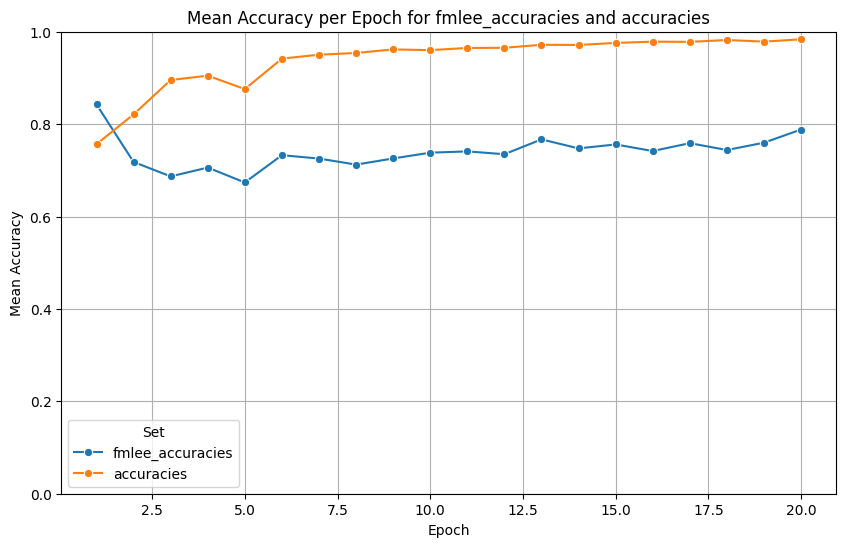

In [43]:
mean_fmlee_accuracies = np.mean(fmlee_accuracies, axis=0)
mean_accuracies = np.mean(accuracies, axis=0)

# Ensure the data is in the range [0, 1]
assert np.all(
    (0 <= mean_fmlee_accuracies) & (mean_fmlee_accuracies <= 1)
), "fmlee_accuracies is not in the range [0, 1]"
assert np.all(
    (0 <= mean_accuracies) & (mean_accuracies <= 1)
), "accuracies is not in the range [0, 1]"

# Number of epochs
epochs = len(mean_fmlee_accuracies)

# Prepare data for plotting
data = {
    "Epoch": list(range(1, epochs + 1)) * 2,
    "Mean Accuracy": list(mean_fmlee_accuracies) + list(mean_accuracies),
    "Set": ["fmlee_accuracies"] * epochs + ["accuracies"] * epochs,
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Epoch", y="Mean Accuracy", hue="Set", marker="o")
plt.title("Mean Accuracy per Epoch for fmlee_accuracies and accuracies")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend(title="Set")
plt.grid(True)
plt.show()

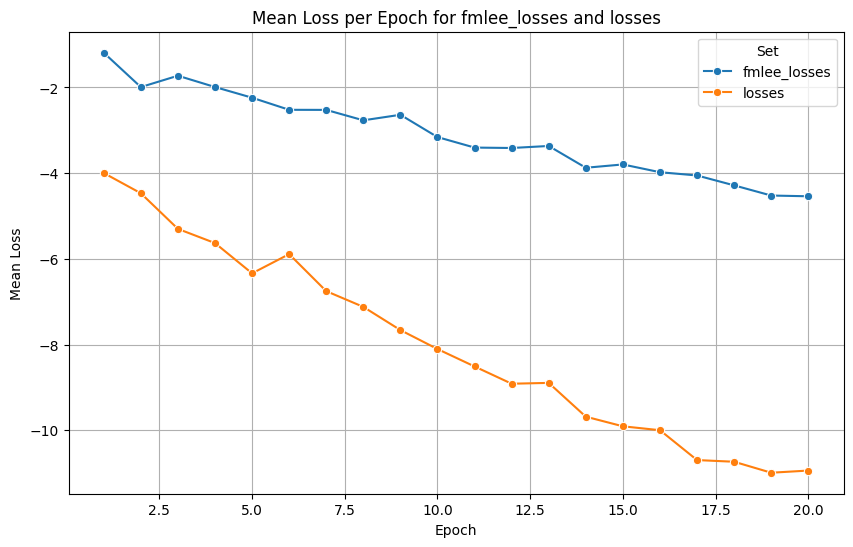

In [44]:
mean_fmlee_losses = np.mean(fmlee_losses, axis=0)
mean_losses = np.mean(losses, axis=0)

# Number of epochs
epochs = len(mean_fmlee_losses)

# Prepare data for plotting
data = {
    "Epoch": list(range(1, epochs + 1)) * 2,
    "Mean Loss": list(mean_fmlee_losses) + list(mean_losses),
    "Set": ["fmlee_losses"] * epochs + ["losses"] * epochs,
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Epoch", y="Mean Loss", hue="Set", marker="o")
plt.title("Mean Loss per Epoch for fmlee_losses and losses")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss")
plt.legend(title="Set")
plt.grid(True)
plt.show()

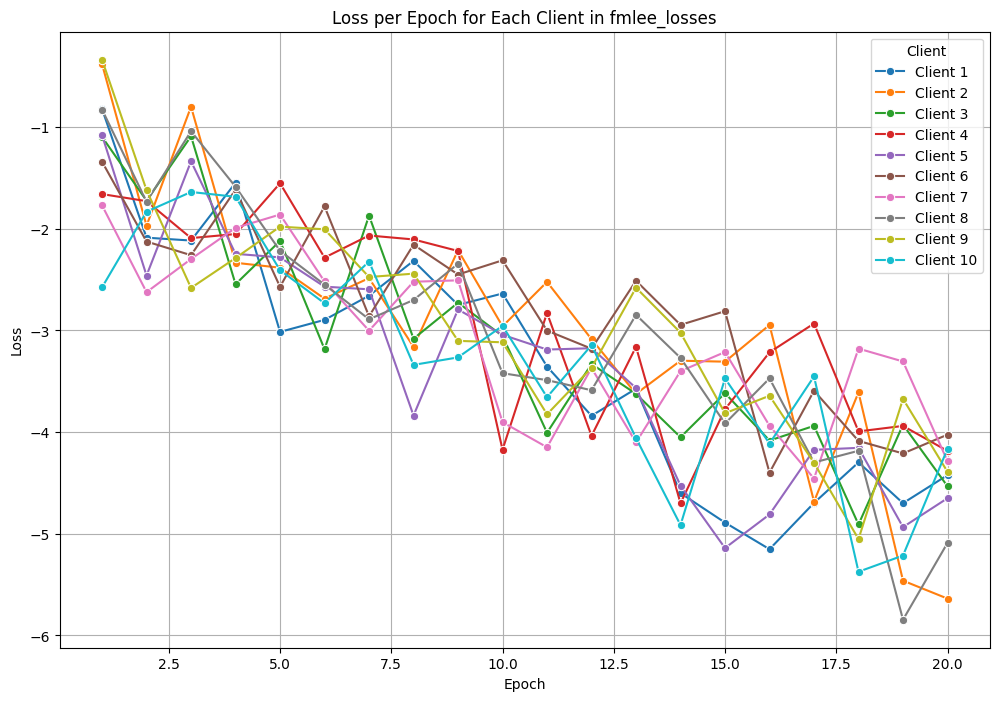

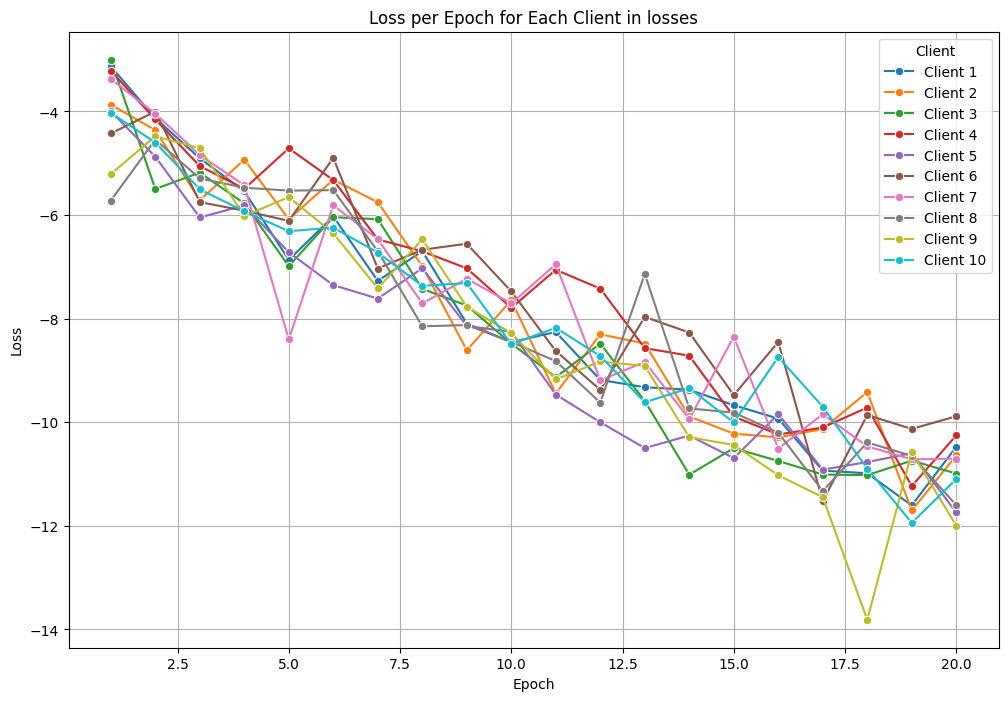

In [45]:
n_clients = len(fmlee_losses)
epochs = len(fmlee_losses[0])

# Prepare data for fmlee_losses plotting
fmlee_data = {"Epoch": [], "Loss": [], "Client": []}

for i in range(n_clients):
    for j in range(epochs):
        fmlee_data["Epoch"].append(j + 1)
        fmlee_data["Loss"].append(fmlee_losses[i][j])
        fmlee_data["Client"].append(f"Client {i + 1}")

# Prepare data for losses plotting
loss_data = {"Epoch": [], "Loss": [], "Client": []}

for i in range(n_clients):
    for j in range(epochs):
        loss_data["Epoch"].append(j + 1)
        loss_data["Loss"].append(losses[i][j])
        loss_data["Client"].append(f"Client {i + 1}")

# Convert to DataFrames
df_fmlee = pd.DataFrame(fmlee_data)
df_loss = pd.DataFrame(loss_data)

# Plotting fmlee_losses
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_fmlee, x="Epoch", y="Loss", hue="Client", marker="o")
plt.title("Loss per Epoch for Each Client in fmlee_losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Client")
plt.grid(True)
plt.show()

# Plotting losses
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_loss, x="Epoch", y="Loss", hue="Client", marker="o")
plt.title("Loss per Epoch for Each Client in losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Client")
plt.grid(True)
plt.show()

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_samples = 100
num_classes = 10
input_shape = (224, 224, 3)

# Generate random images and labels
x_dummy = np.random.rand(num_samples, *input_shape).astype(np.float32)
y_dummy = np.random.randint(0, num_classes, num_samples)

# Convert labels to one-hot encoding
y_dummy = tf.keras.utils.to_categorical(y_dummy, num_classes)

# Load MobileNetV2 with pre-trained weights and exclude the top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model for one epoch
history = model.fit(x_dummy, y_dummy, epochs=1, batch_size=32)

# Print the training history
print(history.history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0584 - loss: 3.3756
{'accuracy': [0.05999999865889549], 'loss': [3.648275136947632]}


In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Define U-Net architecture
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, (2, 2), activation="relu", padding="same")(up6)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Conv2D(512, (3, 3), activation="relu", padding="same")(merge6)
    conv6 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), activation="relu", padding="same")(up7)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, (3, 3), activation="relu", padding="same")(merge7)
    conv7 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), activation="relu", padding="same")(up8)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, (3, 3), activation="relu", padding="same")(merge8)
    conv8 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), activation="relu", padding="same")(up9)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, (3, 3), activation="relu", padding="same")(merge9)
    conv9 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv9)
    conv9 = Conv2D(2, (3, 3), activation="relu", padding="same")(conv9)
    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model


# Create a dummy dataset
num_samples = 100
input_shape = (128, 128, 1)

# Generate random images and labels
x_dummy = np.random.rand(num_samples, *input_shape).astype(np.float32)
y_dummy = np.random.randint(0, 2, (num_samples, 128, 128, 1)).astype(np.float32)

unet_models = []
for _ in range(no_clients):
# Instantiate the U-Net model
    model = unet(input_shape)

    # Compile the model
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    unet_models.append(model)
# Train the model for one epoch
# history = model.fit(x_dummy, y_dummy, epochs=1, batch_size=8)

# Print the training history
# print(history.history)

In [48]:
import time as tm

In [49]:
# import time as tm
# from tqdm import tqdm

# # Initialize total time counters
# total_training_time_unet = 0.0
# total_encryption_time_unet = 0.0
# total_aggregation_time_unet = 0.0
# total_decryption_time_unet = 0.0

# for r in tqdm(range(1)):
#     round_start_time_unet = tm.time()  # Start time for the round

#     for client_id, (client, client_dataset) in enumerate(
#         zip(unet_models, dataset_parts)
#     ):
#         model = client
#         x_train, y_train = client_dataset

#         # Train the model
#         training_start_time_unet = tm.time()
#         history = model.fit(x_dummy, y_dummy, epochs=1, batch_size=8)
#         training_end_time_unet = tm.time()

#         trained_weights = model.get_weights()

#         # Encryption
#         unet_enc_start_time_unet = tm.time()
#         session_key = nacl_session_keygen()
#         client_session_keys[client_id] = session_key
#         enc_session_key = encrypt_symmetric_key(agg_pub_key, session_key)
#         agg_sesion_keys[client_id] = enc_session_key

#         He_ciphertext = HE_encrypt(trained_weights)
#         sym_ctxt = encrypt_message_sym_AES(session_key, He_ciphertext)
#         enc_wts[client_id] = sym_ctxt
#         unet_enc_end_time_unet = tm.time()

#         # Update total training and encryption times
#         total_training_time_unet += training_end_time_unet - training_start_time_unet
#         total_encryption_time_unet += unet_enc_end_time_unet - unet_enc_start_time_unet

#     print(len(enc_wts[0]))

#     # Aggregation
#     unet_agg_start_time_unet = tm.time()
#     agg_wts = aggregate_wts(enc_wts)
#     unet_agg_end_time_unet = tm.time()

#     total_aggregation_time_unet += unet_agg_end_time_unet - unet_agg_start_time_unet

#     for client_id, client in enumerate(fml.clients):
#         # Decryption
#         unet_dec_start_time_unet = tm.time()
#         new_wts = decrypt_wts_ckks(agg_wts)
#         unet_dec_end_time_unet = tm.time()

#         client.set_weights(new_wts)

#         total_decryption_time_unet += unet_dec_end_time_unet - unet_dec_start_time_unet

#     round_end_time_unet = tm.time()  # End time for the round

#     total_round_time_unet = round_end_time_unet - round_start_time_unet

#     print(f"Total training time for round: {total_training_time_unet:.2f} seconds")
#     print(f"Total encryption time for round: {total_encryption_time_unet:.2f} seconds")
#     print(
#         f"Total aggregation time for round: {total_aggregation_time_unet:.2f} seconds"
#     )
#     print(f"Total decryption time for round: {total_decryption_time_unet:.2f} seconds")
#     print(f"Total round time: {total_round_time_unet:.2f} seconds")

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Create a dummy dataset
num_samples = 100
num_classes = 10
input_shape = (224, 224, 3)

# Generate random images and labels
x_dummy = np.random.rand(num_samples, *input_shape).astype(np.float32)
y_dummy = np.random.randint(0, num_classes, num_samples)

# Convert labels to one-hot encoding
y_dummy = tf.keras.utils.to_categorical(y_dummy, num_classes)

# Load ResNet50 with pre-trained weights and exclude the top layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

resnet_models = []
for _ in range(no_clients):
    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

    resnet_models.append(model)
    # 
# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model for one epoch
# history = model.fit(x_dummy, y_dummy, epochs=1, batch_size=32)

# # Print the training history
# print(history.history)

In [51]:
total_training_time_resnet = 0.0
total_encryption_time_resnet = 0.0
total_aggregation_time_resnet = 0.0
total_decryption_time_resnet = 0.0

In [52]:
import time as tm
from tqdm import tqdm

# Initialize total time counters
total_training_time_resnet = 0.0
total_encryption_time_resnet = 0.0
total_aggregation_time_resnet = 0.0
total_decryption_time_resnet = 0.0

for r in tqdm(range(1)):
    round_start_time_resnet = tm.time()  # Start time for the round

    for client_id, (model, client_dataset) in enumerate(
        zip(resnet_models, dataset_parts)
    ):
        # x_train, y_train = client_dataset

        # Train the model
        training_start_time_resnet = tm.time()
        history = model.fit(x_dummy, y_dummy, epochs=1, batch_size=8)
        training_end_time_resnet = tm.time()

        trained_weights = model.get_weights()

        # Encryption
        resnet_enc_start_time_resnet = tm.time()
        session_key = nacl_session_keygen()
        client_session_keys[client_id] = session_key
        enc_session_key = encrypt_symmetric_key(agg_pub_key, session_key)
        agg_sesion_keys[client_id] = enc_session_key

        He_ciphertext = HE_encrypt(trained_weights)
        sym_ctxt = encrypt_message_sym_AES(session_key, He_ciphertext)
        enc_wts[client_id] = sym_ctxt
        resnet_enc_end_time_resnet = tm.time()

        # Update total training and encryption times
        total_training_time_resnet = (
            training_end_time_resnet - training_start_time_resnet
        )
        total_encryption_time_resnet = (
            resnet_enc_end_time_resnet - resnet_enc_start_time_resnet
        )

    print(len(enc_wts[0]))

    # Aggregation
    resnet_agg_start_time_resnet = tm.time()
    agg_wts = aggregate_wts(enc_wts)
    resnet_agg_end_time_resnet = tm.time()

    total_aggregation_time_resnet = (
        resnet_agg_end_time_resnet - resnet_agg_start_time_resnet
    )

    for client_id, client in enumerate(resnet_models):
        # Decryption
        resnet_dec_start_time_resnet = tm.time()
        new_wts = decrypt_wts_ckks(agg_wts)
        resnet_dec_end_time_resnet = tm.time()

        client.set_weights(new_wts)

        total_decryption_time_resnet = (
            resnet_dec_end_time_resnet - resnet_dec_start_time_resnet
        )

    round_end_time_resnet = tm.time()  # End time for the round

    total_round_time_resnet = round_end_time_resnet - round_start_time_resnet

    print(f"Total training time for round: {total_training_time_resnet:.2f} seconds")
    print(
        f"Total encryption time for round: {total_encryption_time_resnet:.2f} seconds"
    )
    print(
        f"Total aggregation time for round: {total_aggregation_time_resnet:.2f} seconds"
    )
    print(
        f"Total decryption time for round: {total_decryption_time_resnet:.2f} seconds"
    )
    print(f"Total round time: {total_round_time_resnet:.2f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.0751 - loss: 3.3633


  0%|          | 0/1 [01:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Create a dummy dataset
num_samples = 100
num_classes = 10
input_shape = (224, 224, 3)

# Generate random images and labels
x_dummy = np.random.rand(num_samples, *input_shape).astype(np.float32)
y_dummy = np.random.randint(0, num_classes, num_samples)

# Convert labels to one-hot encoding
y_dummy = tf.keras.utils.to_categorical(y_dummy, num_classes)

# Load MobileNetV2 with pre-trained weights and exclude the top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

no_clients = 10  # Number of clients

mobilenet_models = []
for _ in range(no_clients):
    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    mobilenet_models.append(model)

# # Example of training the first model for one epoch
# history = mobilenet_models[0].fit(x_dummy, y_dummy, epochs=1, batch_size=32)

# # Print the training history for the first model
# print(history.history)

In [ ]:
import time as tm
from tqdm import tqdm

# Initialize total time counters
total_training_time_mobilenetv2 = 0.0
total_encryption_time_mobilenetv2 = 0.0
total_aggregation_time_mobilenetv2 = 0.0
total_decryption_time_mobilenetv2 = 0.0

for r in tqdm(range(1)):
    round_start_time_mobilenetv2 = tm.time()  # Start time for the round

    for client_id, (model, client_dataset) in enumerate(
        zip(mobilenet_models, dataset_parts)
    ):
        # x_train, y_train = client_dataset

        # Train the model
        training_start_time_mobilenetv2 = tm.time()
        history = model.fit(x_dummy, y_dummy, epochs=1, batch_size=8)
        training_end_time_mobilenetv2 = tm.time()

        trained_weights = model.get_weights()

        # Encryption
        mobilenetv2_enc_start_time_mobilenetv2 = tm.time()
        session_key = nacl_session_keygen()
        client_session_keys[client_id] = session_key
        enc_session_key = encrypt_symmetric_key(agg_pub_key, session_key)
        agg_sesion_keys[client_id] = enc_session_key

        He_ciphertext = HE_encrypt(trained_weights)
        sym_ctxt = encrypt_message_sym_AES(session_key, He_ciphertext)
        enc_wts[client_id] = sym_ctxt
        mobilenetv2_enc_end_time_mobilenetv2 = tm.time()

        # Update total training and encryption times
        total_training_time_mobilenetv2 = (
            training_end_time_mobilenetv2 - training_start_time_mobilenetv2
        )
        total_encryption_time_mobilenetv2 = (
            mobilenetv2_enc_end_time_mobilenetv2
            - mobilenetv2_enc_start_time_mobilenetv2
        )

    print(len(enc_wts[0]))

    # Aggregation
    mobilenetv2_agg_start_time_mobilenetv2 = tm.time()
    agg_wts = aggregate_wts(enc_wts)
    mobilenetv2_agg_end_time_mobilenetv2 = tm.time()

    total_aggregation_time_mobilenetv2 = (
        mobilenetv2_agg_end_time_mobilenetv2 - mobilenetv2_agg_start_time_mobilenetv2
    )

    for client_id, client in enumerate(fml.clients):
        # Decryption
        mobilenetv2_dec_start_time_mobilenetv2 = tm.time()
        new_wts = decrypt_wts_ckks(agg_wts)
        mobilenetv2_dec_end_time_mobilenetv2 = tm.time()

        client.set_weights(new_wts)

        total_decryption_time_mobilenetv2 += (
            mobilenetv2_dec_end_time_mobilenetv2
            - mobilenetv2_dec_start_time_mobilenetv2
        )

    round_end_time_mobilenetv2 = tm.time()  # End time for the round

    total_round_time_mobilenetv2 = (
        round_end_time_mobilenetv2 - round_start_time_mobilenetv2
    )

    print(
        f"Total training time for round: {total_training_time_mobilenetv2:.2f} seconds"
    )
    print(
        f"Total encryption time for round: {total_encryption_time_mobilenetv2:.2f} seconds"
    )
    print(
        f"Total aggregation time for round: {total_aggregation_time_mobilenetv2:.2f} seconds"
    )
    print(
        f"Total decryption time for round: {total_decryption_time_mobilenetv2:.2f} seconds"
    )
    print(f"Total round time: {total_round_time_mobilenetv2:.2f} seconds")

In [ ]:
import matplotlib.pyplot as plt

# Sample data: Replace these with actual times collected from your training runs
total_encryption_time_resnet = 120.0  # Example time in seconds
total_decryption_time_resnet = 80.0
total_aggregation_time_resnet = 60.0

total_encryption_time_mobilenetv2 = 110.0
total_decryption_time_mobilenetv2 = 70.0
total_aggregation_time_mobilenetv2 = 50.0

# Data
models = ["ResNet", "MobileNetV2"]
encryption_times = [total_encryption_time_resnet, total_encryption_time_mobilenetv2]
decryption_times = [total_decryption_time_resnet, total_decryption_time_mobilenetv2]
aggregation_times = [total_aggregation_time_resnet, total_aggregation_time_mobilenetv2]

# Bar width
bar_width = 0.25

# Positions of the bars on the x-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.figure(figsize=(10, 6))

# Bars for encryption times
plt.bar(
    r1,
    encryption_times,
    color="b",
    width=bar_width,
    edgecolor="grey",
    label="Encryption Time",
)

# Bars for decryption times
plt.bar(
    r2,
    decryption_times,
    color="g",
    width=bar_width,
    edgecolor="grey",
    label="Decryption Time",
)

# Bars for aggregation times
plt.bar(
    r3,
    aggregation_times,
    color="r",
    width=bar_width,
    edgecolor="grey",
    label="Aggregation Time",
)

# Adding the labels and title
plt.xlabel("Models", fontweight="bold")
plt.ylabel("Time (seconds)", fontweight="bold")
plt.title("Comparison of Encryption, Decryption, and Aggregation Times")
plt.xticks([r + bar_width for r in range(len(models))], models)

# Adding the legend
plt.legend()

# Show the plot
plt.show()